In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from UnarySim.sw.kernel.conv import *
import matplotlib.pyplot as plt
import time
import math

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [4]:
in_channels = 32
out_channels = 16
kernel_size = (3, 3)
stride = 2
padding = 0
dilation = 1
groups = 1
bias = True
padding_mode = 'zeros'

bitwidth = 8
rounding = "round"

total_bit = 11
input_int_bit = 3
input_fra_bit = total_bit - input_int_bit

input_size = (128, 32)
input = ((torch.rand(32, in_channels, input_size[0], input_size[1]) - 0.5) * 2**(2*input_int_bit)).round().div(2**(input_int_bit)).to(device)

conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias, padding_mode).to(device)
conv2d_o = conv2d(input)

uconv2d = FxpConv2d(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias, padding_mode, 
                        binary_weight=conv2d.weight.data, binary_bias=conv2d.bias, bitwidth=bitwidth, rounding=rounding).to(device)
uconv2d_o = uconv2d(input)

(conv2d_o - uconv2d_o).abs().mean().backward()

diff max: tensor(0.0264, device='cuda:0', grad_fn=<MaxBackward1>)
diff min: tensor(-0.0264, device='cuda:0', grad_fn=<MinBackward1>)
diff mean: tensor(3.9105e-05, device='cuda:0', grad_fn=<MeanBackward0>)


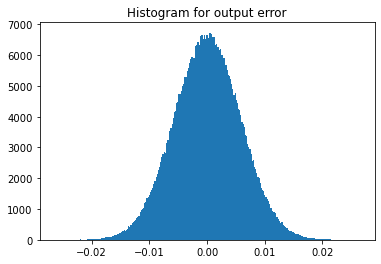

In [5]:
diff = (uconv2d_o - conv2d_o)
print("diff max:", diff.max())
print("diff min:", diff.min())
print("diff mean:", diff.mean())

fig = plt.hist(diff.cpu().detach().numpy().flatten(), bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for output error")
plt.show()

diff grad max: tensor(0.0269, device='cuda:0')
diff grad min: tensor(-0.0267, device='cuda:0')
diff grad mean: tensor(3.6186e-05, device='cuda:0')


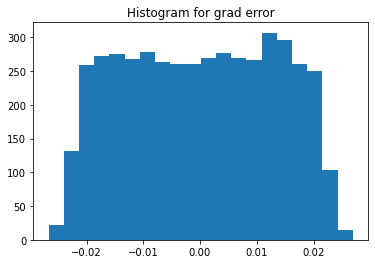

In [6]:
diff_grad = (uconv2d.weight.grad - conv2d.weight.grad)
print("diff grad max:", diff_grad.max())
print("diff grad min:", diff_grad.min())
print("diff grad mean:", diff_grad.mean())

fig = plt.hist(diff_grad.cpu().detach().numpy().flatten(), bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for grad error")
plt.show()

In [7]:
batch = 2
inp = torch.randn(batch, 3, 10, 12)
w_tensor = torch.randn(2, 3, 4, 5)

fc_w = torch.nn.Parameter(w_tensor, requires_grad=True)
fc_inp = torch.nn.functional.unfold(inp, (4, 5))
print("input size: ", fc_inp.size())
fc_inp = fc_inp.transpose(1, 2)
print("input transpose size: ", fc_inp.size())
fc_inp = fc_inp.reshape(-1, fc_inp.size()[-1])
print("input reshape size: ", fc_inp.size())
print()

print("weight size: ", fc_w.size())
fc_w = fc_w.view(fc_w.size(0), -1)
print("weight view size: ", fc_w.size())
fc_w = fc_w.t()
print("weight transpose size: ", fc_w.size())
print()

fc_out = fc_inp.matmul(fc_w)
print("out size: ", fc_out.size())
fc_out = fc_out.reshape(batch, -1, fc_out.size()[-1])
print("out reshape size: ", fc_out.size())
fc_out = fc_out.transpose(1, 2)
print("out transpose size: ", fc_out.size())
fc_out = torch.nn.functional.fold(fc_out, (7, 8), (1, 1))
print("out fold size: ", fc_out.size())
fc_out.sum().backward()
print()

conv_w = torch.nn.Parameter(w_tensor, requires_grad=True)
conv_out = torch.nn.functional.conv2d(inp, conv_w)
conv_out.sum().backward()
(conv_out - fc_out).abs().max()

input size:  torch.Size([2, 60, 56])
input transpose size:  torch.Size([2, 56, 60])
input reshape size:  torch.Size([112, 60])

weight size:  torch.Size([2, 3, 4, 5])
weight view size:  torch.Size([2, 60])
weight transpose size:  torch.Size([60, 2])

out size:  torch.Size([112, 2])
out reshape size:  torch.Size([2, 56, 2])
out transpose size:  torch.Size([2, 2, 56])
out fold size:  torch.Size([2, 2, 7, 8])



tensor(3.8147e-06, grad_fn=<MaxBackward1>)